# 1 Carga datos (Triples + Oraciones)

In [1]:
import json, glob, unicodedata, re
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np

TRIPLES_GLOB = "outputs_triples/*_triples.json"
SENTS_DIR = Path("outputs_sentences")
METRICS_DIR = Path("outputs_metrics")
METRICS_DIR.mkdir(parents=True, exist_ok=True)


def fold(s:str)->str:
    if s is None: return ""
    s = s.casefold()
    return "".join(ch for ch in unicodedata.normalize("NFKD", s) if not unicodedata.combining(ch))

def load_triples(globpat=TRIPLES_GLOB) -> pd.DataFrame:
    rows = []
    for f in sorted(glob.glob(globpat)):
        data = json.load(open(f, "r", encoding="utf-8"))
        doc_id = data.get("doc_id", Path(f).stem.replace("_triples",""))
        for t in data.get("triples", []):
            meta = t.get("meta", {})
            rows.append({
                "doc_id": doc_id,
                "subject": t.get("subject",""),
                "relation": t.get("relation",""),
                "object": t.get("object",""),
                "dep_rule": meta.get("dep_rule",""),
                "conf": float(meta.get("conf", 0.0)),
                "lang": meta.get("lang","und"),
                "sentence_idx": meta.get("sentence_idx", None),
                "sentence_id": meta.get("sentence_id",""),
                "rel_surface": meta.get("rel_surface", None),
                "sent_span": tuple(meta.get("char_span_in_sentence", [0,0])),
                "subj_span": tuple(meta.get("subject_span_in_sentence", [])) or None,
                "obj_span": tuple(meta.get("object_span_in_sentence", [])) or None,
                "file": f,
            })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    # Triples únicos (casefold + sin acentos)
    df["key_fold"] = (df["subject"].map(fold) + "␟" +
                      df["relation"].map(fold) + "␟" +
                      df["object"].map(fold))
    return df

def load_sentences_for(doc_id:str):
    p = SENTS_DIR / f"{doc_id}_sentences.json"
    if not p.exists(): return None
    data = json.load(open(p, "r", encoding="utf-8"))
    sents = data.get("sentences", [])
    # soporta dict o Pydantic-serialized
    def _get_text(s):
        if isinstance(s, dict): return s.get("text") or s.get("sentence") or s.get("content")
        return getattr(s, "text", None) or getattr(s, "sentence", None)
    return [(_get_text(s) or "") for s in sents]

def get_sentence(doc_id:str, idx:int):
    sents = load_sentences_for(doc_id)
    if sents is None or idx is None: return None
    if 0 <= idx < len(sents): return sents[idx]
    return None

df = load_triples()
print("Docs:", df["doc_id"].nunique(), "| Triples:", len(df))
df


Docs: 1 | Triples: 13


,doc_id,subject,relation,object,dep_rule,conf,lang,sentence_idx,sentence_id,rel_surface,sent_span,subj_span,obj_span,file,key_fold
0,DOC-D8124802DFA3,Acme Corp,acquired,Beta Ltd in 2021.,regex_verb_do,0.70,en,2,d04b6b132cb1ff1a,acquired,"(0, 36)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,acme corp␟acquired␟beta ltd in 2021.
1,DOC-D8124802DFA3,Beta Ltd,is,adquirida por Acme Corp.,regex_cop,0.72,es,3,e4257fd621ffba40,es,"(0, 37)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,beta ltd␟is␟adquirida por acme corp.
2,DOC-D8124802DFA3,Acme Corp.,acquired,Beta Ltd,regex_passive_acq,0.82,es,3,e4257fd621ffba40,adquirió,"(0, 37)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,acme corp.␟acquired␟beta ltd
3,DOC-D8124802DFA3,Membership: Member,of,CDO LATAM.,regex_prep,0.60,en,4,532eceea1ae57a69,of,"(0, 32)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,membership: member␟of␟cdo latam.
4,DOC-D8124802DFA3,Author,of,"the book ""Deep Learning 101"".",regex_prep,0.60,en,5,b49335b3e60302a9,of,"(0, 39)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,"author␟of␟the book ""deep learning 101""."
5,DOC-D8124802DFA3,Title: “AI at Scale,in,Mexico City (2020).,regex_prep,0.60,en,6,50ca7a06b724ba6f,in,"(0, 43)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,title: “ai at scale␟in␟mexico city (2020).
6,DOC-D8124802DFA3,Colaboración,with,Universidad Nacional en proyectos de IA aplicada.,regex_prep,0.60,es,7,13d1ff24ff3ad08c,con,"(0, 66)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,colaboracion␟with␟universidad nacional en proy...
7,DOC-D8124802DFA3,La sede,of,Acme está en Madrid.,regex_prep,0.60,es,8,5a9f57157308b46c,de,"(0, 31)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,la sede␟of␟acme esta en madrid.
8,DOC-D8124802DFA3,"Juan Pérez, Director",of,"Analytics, anunció un nuevo modelo de riesgo.",regex_prep,0.60,es,9,ffef0743a944b843,de,"(0, 69)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,"juan perez, director␟of␟analytics, anuncio un ..."
9,DOC-D8124802DFA3,El sistema,is,implementado con enfoque de data mesh.,regex_cop,0.72,es,10,0c835f059bf64345,es,"(0, 53)",None,None,outputs_triples/DOC-D8124802DFA3_triples.json,el sistema␟is␟implementado con enfoque de data...


# 2 Métricas rápidas + distribución

In [2]:
def relation_distribution(df, top_k=20):
    return df["relation"].value_counts().head(top_k)

def rule_distribution(df, top_k=20):
    return df["dep_rule"].value_counts().head(top_k)

def unique_ratio(df):
    return df["key_fold"].nunique() / max(1, len(df))

def conf_stats(df):
    return df["conf"].describe()

print("Unique ratio:", round(unique_ratio(df), 3))
print("\nTop relaciones:")
display(relation_distribution(df, 10).to_frame("count"))

print("\nTop reglas:")
display(rule_distribution(df, 10).to_frame("count"))

print("\nConf stats:")
display(conf_stats(df))


Unique ratio: 1.0

Top relaciones:


,count
relation,
of,5
acquired,2
is,2
in,2
with,2



Top reglas:


,count
dep_rule,
regex_prep,9
regex_cop,2
regex_verb_do,1
regex_passive_acq,1



Conf stats:


count    13.000000
mean      0.643077
std       0.072501
min       0.600000
25%       0.600000
50%       0.600000
75%       0.700000
max       0.820000
Name: conf, dtype: float64

# 3 Gráficas (conf y relaciones)

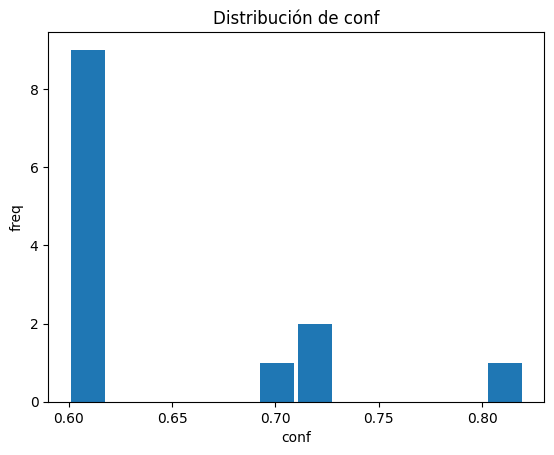

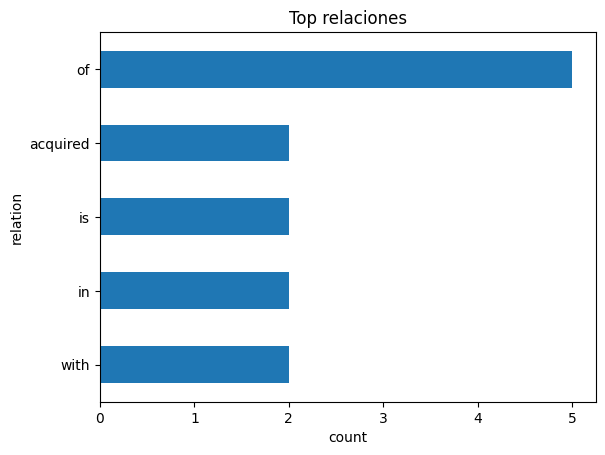

In [3]:
import matplotlib.pyplot as plt

# Histograma de confianza
plt.figure()
df["conf"].plot(kind="hist", bins=12, rwidth=0.9)
plt.title("Distribución de conf")
plt.xlabel("conf")
plt.ylabel("freq")
plt.show()

# Barras de relaciones (top 12)
plt.figure()
relation_distribution(df, 12).iloc[::-1].plot(kind="barh")
plt.title("Top relaciones")
plt.xlabel("count")
plt.ylabel("relation")
plt.show()


# 4 Navegación de ejemplos con contexto de oración

In [4]:
def highlight_span(txt, span, left="[", right="]"):
    if not txt or not span: return txt
    a,b = span
    a = max(0, min(len(txt), int(a))); b = max(0, min(len(txt), int(b)))
    if a>=b: return txt
    return txt[:a] + left + txt[a:b] + right + txt[b:]

def show_examples(df, rel=None, rule=None, doc_id=None, sort_by="conf", asc=False, n=5):
    q = df.copy()
    if rel: q = q[q["relation"]==rel]
    if rule: q = q[q["dep_rule"]==rule]
    if doc_id: q = q[q["doc_id"]==doc_id]
    if q.empty:
        print("No hay ejemplos.")
        return
    q = q.sort_values(sort_by, ascending=asc).head(n)
    for i, r in q.iterrows():
        sent = get_sentence(r.doc_id, r.sentence_idx) or ""
        # muestra también el span de la oración completo y marca sujeto/objeto si existen
        sent_h = highlight_span(sent, r.get("subj_span")) if r.get("subj_span") else sent
        sent_h = highlight_span(sent_h, r.get("obj_span"))
        print(f"doc={r.doc_id} | conf={r.conf:.2f} | lang={r.lang} | rule={r.dep_rule}")
        print(f"S: {r.subject}\nR: {r.relation} (surface={r.rel_surface})\nO: {r.object}")
        print("SENT:", sent_h)
        print("-"*90)

# Ejemplos: peores confs (para auditar ruido)
show_examples(df, sort_by="conf", asc=True, n=6)

# Ejemplos: por relación 'works_at' / 'in' / 'alias'
show_examples(df, rel="works_at", n=5)
show_examples(df, rel="in", n=5)
show_examples(df, rel="alias", n=5)


doc=DOC-D8124802DFA3 | conf=0.60 | lang=en | rule=regex_prep
S: Membership: Member
R: of (surface=of)
O: CDO LATAM.
SENT: Membership: Member of CDO LATAM.
------------------------------------------------------------------------------------------
doc=DOC-D8124802DFA3 | conf=0.60 | lang=es | rule=regex_prep
S: Colaboración
R: with (surface=con)
O: Universidad Nacional en proyectos de IA aplicada.
SENT: Colaboración con Universidad Nacional en proyectos de IA aplicada.
------------------------------------------------------------------------------------------
doc=DOC-D8124802DFA3 | conf=0.60 | lang=en | rule=regex_prep
S: Title: “AI at Scale
R: in (surface=in)
O: Mexico City (2020).
SENT: Title: “AI at Scale” in Mexico City (2020).
------------------------------------------------------------------------------------------
doc=DOC-D8124802DFA3 | conf=0.60 | lang=en | rule=regex_prep
S: Author
R: of (surface=of)
O: the book "Deep Learning 101".
SENT: Author of the book "Deep Learning 101".
--

# 5 Heurística simple de “calidad” (flags)

In [5]:
URL_RE = re.compile(r"(https?://|www\.)", re.I)
EMAIL_RE = re.compile(r"\b\S+@\S+\.\S+\b")
PHONE_RE = re.compile(r"\+?\d[\d\s\-\(\)]{7,}")
def digits_ratio(s): 
    s = s or ""
    d = sum(1 for ch in s if ch.isdigit())
    return d / max(1, len(s))

GENERIC_PREPS = {"of","in","with","de","en","con"}

def flag_row(r):
    flags = []
    # relaciones demasiado genéricas con objetos/sujetos cortos
    if r["relation"] in GENERIC_PREPS and (len(r["object"])<4 or len(r["subject"])<4):
        flags.append("generic+short")
    # alto contenido numérico
    if digits_ratio(r["subject"])>0.35 or digits_ratio(r["object"])>0.35:
        flags.append("digits")
    # contacto
    sent = get_sentence(r.doc_id, r.sentence_idx) or ""
    if URL_RE.search(sent) or EMAIL_RE.search(sent) or PHONE_RE.search(sent):
        flags.append("contact-like")
    # baja confianza
    if r["conf"] < 0.7: 
        flags.append("low-conf")
    # alias con números
    if r["relation"]=="alias" and (digits_ratio(r["object"])>0.2 or digits_ratio(r["subject"])>0.2):
        flags.append("alias-num")
    return "|".join(flags) if flags else ""

df["flags"] = df.apply(flag_row, axis=1)
display(df["flags"].value_counts().to_frame("count"))

suspects = df[df["flags"]!=""].sort_values(["flags","conf"])
suspects.head(10)[["doc_id","subject","relation","object","conf","dep_rule","flags"]]


,count
flags,
low-conf,9
,4


,doc_id,subject,relation,object,conf,dep_rule,flags
3,DOC-D8124802DFA3,Membership: Member,of,CDO LATAM.,0.6,regex_prep,low-conf
4,DOC-D8124802DFA3,Author,of,"the book ""Deep Learning 101"".",0.6,regex_prep,low-conf
5,DOC-D8124802DFA3,Title: “AI at Scale,in,Mexico City (2020).,0.6,regex_prep,low-conf
6,DOC-D8124802DFA3,Colaboración,with,Universidad Nacional en proyectos de IA aplicada.,0.6,regex_prep,low-conf
7,DOC-D8124802DFA3,La sede,of,Acme está en Madrid.,0.6,regex_prep,low-conf
8,DOC-D8124802DFA3,"Juan Pérez, Director",of,"Analytics, anunció un nuevo modelo de riesgo.",0.6,regex_prep,low-conf
10,DOC-D8124802DFA3,El sistema fue implementado,with,enfoque de data mesh.,0.6,regex_prep,low-conf
11,DOC-D8124802DFA3,Master,of,Science in Data Science at MIT (2018–2020).,0.6,regex_prep,low-conf
12,DOC-D8124802DFA3,Licenciatura,in,Matemáticas en UNAM (2012–2016).,0.6,regex_prep,low-conf


# 6 “Score” heurístico y resumen de calidad

In [6]:
def rule_weight(rule:str)->float:
    strong = {"VERB_dobj_nsubj","nsubj_cop_attr","VERB_prep_pobj_nsubj","PASSIVE_agent_pobj","VERB_work_prep_org"}
    medium = {"NOUN_prep_pobj","COP_title_prep_org","regex_is_title_at","regex_works_at","regex_passive_acq","regex_cop"}
    return 1.0 if rule in strong else (0.85 if rule in medium else 0.7)

def quality_score(row):
    score = row["conf"] * rule_weight(row["dep_rule"])
    if "contact-like" in (row["flags"] or ""): score *= 0.4
    if "digits" in (row["flags"] or ""): score *= 0.6
    if "generic+short" in (row["flags"] or ""): score *= 0.7
    return round(score, 3)

df["q_score"] = df.apply(quality_score, axis=1)

print("q_score stats:")
display(df["q_score"].describe())

print("\nSospechosos (q_score bajo):")
display(df.sort_values("q_score").head(10)[["doc_id","subject","relation","object","conf","dep_rule","flags","q_score"]])


q_score stats:


count    13.000000
mean      0.476231
std       0.097576
min       0.420000
25%       0.420000
50%       0.420000
75%       0.490000
max       0.697000
Name: q_score, dtype: float64


Sospechosos (q_score bajo):


,doc_id,subject,relation,object,conf,dep_rule,flags,q_score
3,DOC-D8124802DFA3,Membership: Member,of,CDO LATAM.,0.6,regex_prep,low-conf,0.42
6,DOC-D8124802DFA3,Colaboración,with,Universidad Nacional en proyectos de IA aplicada.,0.6,regex_prep,low-conf,0.42
5,DOC-D8124802DFA3,Title: “AI at Scale,in,Mexico City (2020).,0.6,regex_prep,low-conf,0.42
4,DOC-D8124802DFA3,Author,of,"the book ""Deep Learning 101"".",0.6,regex_prep,low-conf,0.42
7,DOC-D8124802DFA3,La sede,of,Acme está en Madrid.,0.6,regex_prep,low-conf,0.42
11,DOC-D8124802DFA3,Master,of,Science in Data Science at MIT (2018–2020).,0.6,regex_prep,low-conf,0.42
10,DOC-D8124802DFA3,El sistema fue implementado,with,enfoque de data mesh.,0.6,regex_prep,low-conf,0.42
8,DOC-D8124802DFA3,"Juan Pérez, Director",of,"Analytics, anunció un nuevo modelo de riesgo.",0.6,regex_prep,low-conf,0.42
12,DOC-D8124802DFA3,Licenciatura,in,Matemáticas en UNAM (2012–2016).,0.6,regex_prep,low-conf,0.42
0,DOC-D8124802DFA3,Acme Corp,acquired,Beta Ltd in 2021.,0.7,regex_verb_do,,0.49


# 7 Exporta una muestra para anotación manual (CSV)

In [7]:
# Asegura carpeta de métricas
METRICS_DIR = Path("outputs_metrics")
METRICS_DIR.mkdir(parents=True, exist_ok=True)

SAMPLE_K = 40
SAMPLE_K = min(SAMPLE_K, len(df))
if SAMPLE_K == 0:
    print("No hay triples para muestrear.")
else:
    # usa extremos por q_score con índices limpios
    lo = df.nsmallest(SAMPLE_K // 2, "q_score")
    hi = df.nlargest(SAMPLE_K - SAMPLE_K // 2, "q_score")
    sample = pd.concat([lo, hi], ignore_index=True) \
               .sample(frac=1, random_state=13) \
               .reset_index(drop=True)

    def add_context(row):
        sent = get_sentence(row.doc_id, row.sentence_idx) or ""
        span = row.get("sent_span", None)
        a, b = (0, 0)
        if isinstance(span, (list, tuple)) and len(span) == 2:
            a, b = int(span[0] or 0), int(span[1] or 0)
        frag = sent[max(0, a-40):min(len(sent), b+40)]
        return pd.Series({"sentence": sent, "frag": frag})

    ctx = sample.apply(add_context, axis=1)              # índice alineado con 'sample'
    sample_out = pd.concat([sample, ctx], axis=1)

    cols = ["doc_id","subject","relation","object","conf","dep_rule","flags","q_score","sentence","frag"]
    cols = [c for c in cols if c in sample_out.columns]
    sample_out = sample_out[cols]

    out_path = METRICS_DIR / "triple_audit_sample.csv"
    sample_out.to_csv(out_path, index=False, encoding="utf-8")
    print("Guardado:", out_path.as_posix())
    display(sample_out.head(5))

Guardado: outputs_metrics/triple_audit_sample.csv


,doc_id,subject,relation,object,conf,dep_rule,flags,q_score,sentence,frag
0,DOC-D8124802DFA3,"Juan Pérez, Director",of,"Analytics, anunció un nuevo modelo de riesgo.",0.60,regex_prep,low-conf,0.420,"Juan Pérez, Director de Analytics, anunció un ...","Juan Pérez, Director de Analytics, anunció un ..."
1,DOC-D8124802DFA3,Acme Corp,acquired,Beta Ltd in 2021.,0.70,regex_verb_do,,0.490,Acme Corp acquired Beta Ltd in 2021.,Acme Corp acquired Beta Ltd in 2021.
2,DOC-D8124802DFA3,Colaboración,with,Universidad Nacional en proyectos de IA aplicada.,0.60,regex_prep,low-conf,0.420,Colaboración con Universidad Nacional en proye...,Colaboración con Universidad Nacional en proye...
3,DOC-D8124802DFA3,Beta Ltd,is,adquirida por Acme Corp.,0.72,regex_cop,,0.612,Beta Ltd fue adquirida por Acme Corp.,Beta Ltd fue adquirida por Acme Corp.
4,DOC-D8124802DFA3,El sistema,is,implementado con enfoque de data mesh.,0.72,regex_cop,,0.612,El sistema fue implementado con enfoque de dat...,El sistema fue implementado con enfoque de dat...


# 8 Métrica rápida de precisión estimada con la muestra anotada

In [8]:
# === 8) Precisión estimada desde la muestra anotada (lee de outputs_metrics) ===
import pandas as pd
from pathlib import Path

METRICS_DIR = Path("outputs_metrics")
ann_path = METRICS_DIR / "triple_audit_sample.csv"

try:
    ann = pd.read_csv(ann_path)
    if "label" in ann.columns:
        # acepta TP/FP o 1/0 (case-insensitive)
        lab = ann["label"].astype(str).str.strip().str.upper()
        lab = lab.replace({"1":"TP", "0":"FP", "TRUE":"TP", "FALSE":"FP"})
        prec = (lab == "TP").mean() if len(lab) else float("nan")
        n = len(lab)
        print(f"Precisión estimada (muestra): {prec:.3f}  |  n={n}")
        # si quieres guardar el resultado:
        (METRICS_DIR / "precision_estimate.txt").write_text(f"precision={prec:.4f}, n={n}\n", encoding="utf-8")
    else:
        print("Añade columna 'label' (TP/FP) en", ann_path.as_posix(), "para estimar precisión.")
except FileNotFoundError:
    print("No se encontró", ann_path.as_posix(), "→ ejecuta la celda 7 primero.")


Añade columna 'label' (TP/FP) en outputs_metrics/triple_audit_sample.csv para estimar precisión.
